## Import Packages & Load CSV files

In [1]:
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
# Load the CSV/Excel files
bad_df = pd.read_csv('BAD.csv')
drll_df = pd.read_csv('DRLL.csv')
susa_df = pd.read_csv('SUSA.csv')
esgu_df = pd.read_csv('ESGU.csv')
sp500_df = pd.read_csv('sp500.csv')

# Display the first few rows of each dataframe
bad_head = bad_df.head()
drll_head = drll_df.head()
susa_head = susa_df.head()
esgu_head = esgu_df.head()
sp500_head = sp500_df.head()

bad_head, drll_head, susa_head, esgu_head, sp500_head

(         Date     Open   High     Low    Close  Adj Close    Volume
 0  2021-12-21  15.0000  15.00  15.000  15.0000    15.0000       0.0
 1  2021-12-22  15.0046  15.16  15.000  15.0703    15.0703  448019.0
 2  2021-12-23  15.2700  15.27  15.067  15.2234    15.2234   53295.0
 3  2021-12-27  15.3300  16.43  15.085  15.2000    15.2000   24534.0
 4  2021-12-28  15.2000  15.30  15.050  15.0800    15.0800   13192.0,
          Date       Open       High        Low      Close  Adj Close   Volume
 0  2022-08-09  25.799999  25.860001  25.450001  25.570000  24.517891  1066800
 1  2022-08-10  26.000000  26.129999  25.160000  25.760000  24.700077  1537500
 2  2022-08-11  26.330000  26.809999  26.170000  26.610001  25.515100  1498000
 3  2022-08-12  26.660000  26.841999  26.360001  26.820000  25.716457  1031200
 4  2022-08-15  26.170000  26.511999  25.750000  26.370001  25.284975  1022300,
       Date       Open       High        Low   Close  Adj Close  Volume
 0  28/1/05  25.055000  25.055000  24.

## Comparing Cummulative Returns

In [3]:
# Convert 'Date' columns to datetime objects
end_date = pd.to_datetime("2023-12-1")
bad_df['Date'] = pd.to_datetime(bad_df['Date'])
drll_df['Date'] = pd.to_datetime(drll_df['Date'])
esgu_df['Date'] = pd.to_datetime(esgu_df['Date'])
susa_df['Date'] = pd.to_datetime(susa_df['Date'])
sp500_df['Date'] = pd.to_datetime(sp500_df['Date'])

bad_df = bad_df[bad_df['Date'] <= end_date]
drll_df = drll_df[drll_df['Date'] <= end_date]
esgu_df = esgu_df[esgu_df['Date'] <= end_date]
susa_df = susa_df[susa_df['Date'] <= end_date]
sp500_df = sp500_df[sp500_df['Date'] <= end_date]


# Calculate daily returns
bad_df['Daily Returns'] = bad_df['Adj Close'].pct_change()
drll_df['Daily Returns'] = drll_df['Adj Close'].pct_change()
esgu_df['Daily Returns'] = esgu_df['Adj Close'].pct_change()
susa_df['Daily Returns'] = susa_df['Adj Close'].pct_change()
sp500_df['Daily Returns'] = sp500_df['Adj Close'].pct_change()

/var/folders/f7/t51lvbwn6_xg2vbn66mndyq40000gn/T/ipykernel_39483/2583358881.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  susa_df['Date'] = pd.to_datetime(susa_df['Date'])


In [4]:
# Merge ETF dataframes on 'Date' column
merged_df = pd.merge(bad_df[['Date', 'Daily Returns']], drll_df[['Date', 'Daily Returns']], on='Date', how='outer', suffixes=('_BAD', '_DRLL'))
merged_df = pd.merge(merged_df, esgu_df[['Date', 'Daily Returns']], on='Date', how='outer')
merged_df = pd.merge(merged_df, susa_df[['Date', 'Daily Returns']], on='Date', how='outer', suffixes=('_ESGU', '_SUSA'))
merged_df = pd.merge(merged_df, sp500_df[['Date', 'Daily Returns']], on='Date', how='outer')
merged_df.set_index('Date', inplace=True)
merged_df.columns = ['BAD', 'DRLL', 'ESGU', 'SUSA', 'SP500']

# Drop NaN values that arise from mismatches in trading dates between the ETFs
merged_df.dropna(inplace=True)

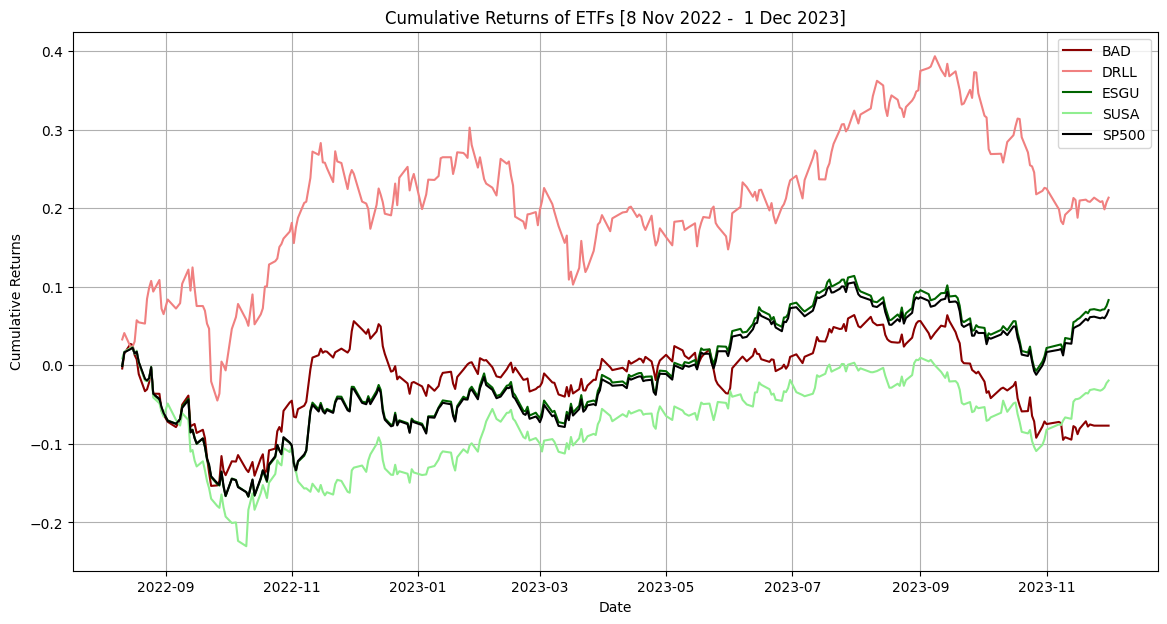

In [5]:
# Calculate cumulative returns for plotting
cumulative_returns = (1 + merged_df).cumprod() - 1

# Plotting the cumulative returns
plt.figure(figsize=(14, 7))
plt.plot(cumulative_returns.index, cumulative_returns['BAD'], label='BAD', color='darkred')
plt.plot(cumulative_returns.index, cumulative_returns['DRLL'], label='DRLL', color='lightcoral')
plt.plot(cumulative_returns.index, cumulative_returns['ESGU'], label='ESGU', color='darkgreen')
plt.plot(cumulative_returns.index, cumulative_returns['SUSA'], label='SUSA', color='lightgreen')
plt.plot(cumulative_returns.index, cumulative_returns['SP500'], label='SP500', color='black')

# Adding title and labels
plt.title('Cumulative Returns of ETFs [8 Nov 2022 -  1 Dec 2023]')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

## Sharpe Ratio

In [6]:
# Function to calculate annualized Sharpe Ratio
def calculate_sharpe_ratio(df, risk_free_rate):
    # Calculate daily returns
    df['Daily Returns'] = df['Adj Close'].pct_change()

    # Calculate mean and standard deviation of daily returns
    mean_daily_return = df['Daily Returns'].mean()
    std_daily_return = df['Daily Returns'].std()

    # Annualize the mean and standard deviation
    mean_annual_return = mean_daily_return * 252
    std_annual_return = std_daily_return * (252 ** 0.5)

    # Calculate Sharpe Ratio
    sharpe_ratio = (mean_annual_return - risk_free_rate) / std_annual_return
    return sharpe_ratio

In [7]:
# Define the annual risk-free rate
annual_risk_free_rate = 0.0419  # 4.19%

# Calculate Sharpe Ratios for each ETF
sharpe_ratio_bad = calculate_sharpe_ratio(bad_df, annual_risk_free_rate)
sharpe_ratio_drll = calculate_sharpe_ratio(drll_df, annual_risk_free_rate)
sharpe_ratio_susa = calculate_sharpe_ratio(susa_df, annual_risk_free_rate)
sharpe_ratio_esgu = calculate_sharpe_ratio(esgu_df, annual_risk_free_rate)
sharpe_ratio_sp500 = calculate_sharpe_ratio(sp500_df, annual_risk_free_rate)

sharpe_ratio_bad, sharpe_ratio_drll, sharpe_ratio_susa, sharpe_ratio_esgu, sharpe_ratio_sp500

(-0.6206667799176728,
 0.3854929900190148,
 0.33732741847119163,
 0.5048466363319977,
 0.31956681186540414)

## T-test

In [8]:
# Function to perform a t-test between two ETFs
def perform_ttest(df1, df2, column_name='Adj Close'):
    # Calculate daily returns for each ETF
    df1_returns = df1[column_name].pct_change().dropna()
    df2_returns = df2[column_name].pct_change().dropna()

    # Perform t-test
    t_stat, p_value = stats.ttest_ind(df1_returns, df2_returns, equal_var=False)
    return t_stat, p_value

In [9]:
# Performing pairwise t-tests
ttest_results = {}

# Pairwise combinations
etfs = [("BAD", bad_df), ("DRLL", drll_df), ("SUSA", susa_df), ("ESGU", esgu_df),("SP500", sp500_df)]
for i in range(len(etfs)):
    for j in range(i+1, len(etfs)):
        etf1_name, etf1_df = etfs[i]
        etf2_name, etf2_df = etfs[j]
        key = f"{etf1_name} vs {etf2_name}"
        ttest_results[key] = perform_ttest(etf1_df, etf2_df)

ttest_results

{'BAD vs DRLL': (-0.8620627705399576, 0.38897585361047227),
 'BAD vs SUSA': (-1.2184198477518051, 0.22357516829557125),
 'BAD vs ESGU': (-1.3482530537147936, 0.1780035990591509),
 'BAD vs SP500': (-1.2102125176723832, 0.22674948256721028),
 'DRLL vs SUSA': (0.154533700753025, 0.8772766704868588),
 'DRLL vs ESGU': (-0.003722413451273244, 0.9970317748326927),
 'DRLL vs SP500': (0.18060413268041026, 0.8567858432378671),
 'SUSA vs ESGU': (-0.417297790865558, 0.6764902911107402),
 'SUSA vs SP500': (0.10655675005667509, 0.9151430730563197),
 'ESGU vs SP500': (0.521444513973402, 0.6021080866944222)}

### Statistical Conclusion

In all cases, the p-values are greater than the common alpha level of 0.05. This suggests that we cannot reject the null hypothesis of equal means for any of the pairs. In other words, the differences in the daily returns of these ETFs are not statistically significant at the 5% significance level

## Correlation Matrix

In [10]:
# Prepare the data for correlation matrix calculation
etfs_data = {
    'BAD': bad_df['Adj Close'],
    'DRLL': drll_df['Adj Close'],
    'SUSA': susa_df['Adj Close'],
    'ESGU': esgu_df['Adj Close'],
    'SP500': sp500_df['Adj Close']
}

etfs_returns = pd.DataFrame(etfs_data)

# Calculate daily returns for correlation
etfs_daily_returns = etfs_returns.pct_change().dropna()

# Calculate the correlation matrix
correlation_matrix = etfs_daily_returns.corr()
correlation_matrix

/var/folders/f7/t51lvbwn6_xg2vbn66mndyq40000gn/T/ipykernel_39483/2056209897.py:13: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  etfs_daily_returns = etfs_returns.pct_change().dropna()


,BAD,DRLL,SUSA,ESGU,SP500
BAD,1.000000,0.030801,-0.008252,0.000074,0.004805
DRLL,0.030801,1.000000,0.013573,0.010955,0.018561
SUSA,-0.008252,0.013573,1.000000,-0.028102,-0.003066
ESGU,0.000074,0.010955,-0.028102,1.000000,0.008074
SP500,0.004805,0.018561,-0.003066,0.008074,1.000000


### Observations 

- Low Correlation: The correlations among these ETFs are quite low. The correlation coefficients are close to zero in most cases, suggesting little to no linear relationship between the daily returns of these ETFs.

- Diversification Potential: The low correlation between these ETFs implies potential for diversification. Adding these ETFs to a portfolio could help in spreading risk, as their returns do not move strongly in tandem.

- Independent Performance: The low correlation suggests that the ETFs are responding to different factors or market conditions, indicating a degree of independence in their performance.

- Investment Strategy Considerations: For investors seeking to build a diversified portfolio, combining these ETFs might be an effective strategy, as their returns don't appear to be significantly affected by the same market movements.

## Multivariate Approach

In [11]:
# Function to perform multivariate regression for each ETF as the dependent variable
def multivariate_regression_for_etf(dependent_var, independent_vars):
    X = independent_vars.drop(columns=[dependent_var])  # Independent variables
    y = independent_vars[dependent_var]  # Dependent variable

    # Adding a constant to the model (intercept)
    X = sm.add_constant(X)

    # Building and fitting the multivariate regression model
    model = sm.OLS(y, X).fit()
    return model.summary()

In [12]:
# Running multivariate regression for each ETF
regression_results_all_etfs = {}
for etf in etfs_daily_returns.columns:
    regression_results_all_etfs[etf] = multivariate_regression_for_etf(etf, etfs_daily_returns)

In [13]:
print(regression_results_all_etfs['SUSA'])

                            OLS Regression Results                            
Dep. Variable:                   SUSA   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.892
Date:                Thu, 18 Jan 2024   Prob (F-statistic):             0.0209
Time:                        13:10:14   Log-Likelihood:                 37254.
No. Observations:               10833   AIC:                        -7.450e+04
Df Residuals:                   10828   BIC:                        -7.446e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002   7.47e-05      2.487      0.0

In [14]:
print(regression_results_all_etfs['DRLL'])

                            OLS Regression Results                            
Dep. Variable:                   DRLL   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     4.354
Date:                Thu, 18 Jan 2024   Prob (F-statistic):            0.00161
Time:                        13:10:14   Log-Likelihood:                 48364.
No. Observations:               10833   AIC:                        -9.672e+04
Df Residuals:                   10828   BIC:                        -9.668e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.414e-05   2.68e-05      0.528      0.5

In [15]:
print(regression_results_all_etfs['ESGU'])

                            OLS Regression Results                            
Dep. Variable:                   ESGU   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.653
Date:                Thu, 18 Jan 2024   Prob (F-statistic):             0.0313
Time:                        13:10:14   Log-Likelihood:                 42125.
No. Observations:               10833   AIC:                        -8.424e+04
Df Residuals:                   10828   BIC:                        -8.420e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.203e-05   4.77e-05      1.931      0.0

In [16]:
print(regression_results_all_etfs['BAD'])

                            OLS Regression Results                            
Dep. Variable:                    BAD   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.823
Date:                Thu, 18 Jan 2024   Prob (F-statistic):             0.0235
Time:                        13:10:14   Log-Likelihood:                 47774.
No. Observations:               10833   AIC:                        -9.554e+04
Df Residuals:                   10828   BIC:                        -9.550e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.731e-05   2.83e-05     -0.612      0.5